In [1]:
from nltk.corpus import wordnet as wn
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras
import keras.utils
from keras import utils as np_utils
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Embedding
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

Using TensorFlow backend.
c:\users\gulja\python 3.7.3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\gulja\python 3.7.3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\gulja\python 3.7.3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\gulja\python 3.7.3\lib\site-packages\tensorflow\python\framewo

In [2]:
df_data=pd.read_csv('labels.csv')
events= pd.read_csv('eventsummary.csv')

In [3]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t,m) for w, p, t,m in zip(s["Words"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist(),
                                                           s["Tag2"].values.tolist())]
        self.grouped = self.data.groupby("event_id").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

In [4]:
words = set(df_data["Words"].values.tolist())


In [5]:
getter = SentenceGetter(df_data)

# Get sentence data
sentences1 = [[s[0] for s in sent] for sent in getter.sentences]
sentences1[0]
sentences = getter.sentences
# # Get tag labels data
# labels = [[s[2] for s in sent] for sent in getter.sentences]
# print(labels[0])

In [6]:
sentences1 = [" ".join([s[0] for s in sent]) for sent in getter.sentences]
sentences1[0]

'A shooting takes place at  a  pub  in  Tel Aviv Israel leaving two dead  and  eight injured gunman managed to escape possibly killed his accomplice an Arab taxi driver whose body was found nearby police identified shooter  as  30 year old muslim Nisaat Melkham from Arara searched home'

In [7]:
labels = [[s[2] for s in sent] for sent in getter.sentences]
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'arg', 'O', 'arg', 'arg', 'arg', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [8]:
word_tokenizer = Tokenizer()
print(word_tokenizer.fit_on_texts(sentences1))
vocab_length = len(word_tokenizer.word_index) + 1
embedded_sentences = word_tokenizer.texts_to_sequences(sentences1)


None


In [9]:
from nltk.tokenize import word_tokenize

word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(sentences1, key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))

padded_sentences = pad_sequences(embedded_sentences, length_long_sentence, padding='post')

print(length_long_sentence)

258


In [10]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences1], bins=10)
plt.show()

<Figure size 640x480 with 1 Axes>

In [11]:
X=padded_sentences
max_len=length_long_sentence
# words = set(df["Words"].values.tolist())
# # words.append("ENDPAD")
# n_words = len(words); 
tags = set(df_data["Tag"].values.tolist())
n_tags = len(tags); 
tags2 = set(df_data["Tag2"].values.tolist())
n_tags2 = len(tags2); 
sent = getter.get_next()
# word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)} #vocab for tags arguments
tag22idx = {t: i for i, t in enumerate(tags2)} #vocab for tags relation
# from keras.preprocessing.sequence import pad_sequences
# X = [[word2idx[w[0]] for w in s] for s in sentences]
# X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)


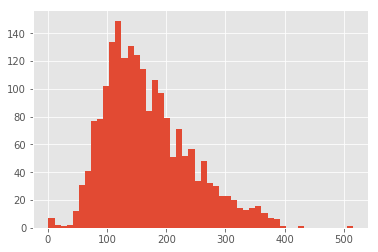

In [12]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences1], bins=50)
plt.show()

In [13]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

72


In [14]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [15]:
X_char = []
max_len_char = 10
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [16]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
y = [to_categorical(i, num_classes=n_tags) for i in y]
#.....................output 2 label Relations..........................
y1 = [[tag22idx[w[3]] for w in s] for s in sentences]
y1 = pad_sequences(maxlen=max_len, sequences=y1, padding="post", value=tag22idx["O"])
y1 = [to_categorical(i, num_classes=n_tags2) for i in y1]
# print(y)

In [17]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('C:/Users/gulja/Python 3.7.3/Scripts/thesis/2020/Word Embeddings/glove.6B.100d.txt', encoding="utf8")


In [18]:
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

In [19]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [20]:
len(X)

2018

In [21]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [22]:
X_tr, X_te, y_tr, y_te,y1_tr, y1_te = train_test_split(X,y, y1, test_size=0.1)
X_char_tr, X_char_te, _, _,_, _ = train_test_split(X_char, y,y1, test_size=0.1, random_state=2018)


In [23]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

In [24]:
from keras import optimizers
from keras.callbacks import EarlyStopping
input = Input(shape=(max_len,))
emb_word = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=length_long_sentence)(input)
# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(x)
out = TimeDistributed(Dense(n_tags, activation="sigmoid"))(model)  # softmax output layer
out1 = TimeDistributed(Dense(n_tags2, activation="sigmoid"))(model) 
model = Model([input,char_in], [out,out1])
adam1 = optimizers.adam(lr=0.01)
model.compile(optimizer=adam1,loss="binary_crossentropy", metrics=["accuracy",f1_m,precision_m, recall_m])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [25]:
from keras.utils.vis_utils import plot_model

In [26]:
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# What I did are followed:
model.summary()
import keras
import pydot_ng as pydot
pydot.find_graphviz()
plot_model(model, to_file='model_plot.png', show_shapes=False, show_layer_names=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 258, 10)      0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 258)          0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 258, 10, 10)  740         input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 258, 100)     979100      input_1[0][0]                    
__________________________________________________________________________________________________
time_distr

In [27]:
# history = model.fit(X_tr, [np.array(y_tr),np.array(y1_tr)], batch_size=32, epochs=5, validation_split=0.1, verbose=1)
# X_tr, X_te, y_tr, y_te,y1_tr, y1_te = train_test_split(X,y, y1, test_size=0.1)
# X_char_tr, X_char_te, _, _,_, _ = train_test_split(X_char, y,y1, test_size=0.1, random_state=2018)


In [28]:
history = model.fit([X_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                   [np.array(y_tr),np.array(y1_tr)],
                    batch_size=32, epochs=20, validation_split=0.1, verbose=1,  callbacks=[es])

Instructions for updating:
Use tf.cast instead.
Train on 1634 samples, validate on 182 samples
Epoch 1/20
1634/1634 [==============================] - 46s 28ms/step - loss: 0.5727 - time_distributed_3_loss: 0.3735 - time_distributed_4_loss: 0.1992 - time_distributed_3_acc: 0.8223 - time_distributed_3_f1_m: 0.9709 - time_distributed_3_precision_m: 0.9727 - time_distributed_3_recall_m: 0.9697 - time_distributed_4_acc: 0.9339 - time_distributed_4_f1_m: 0.9817 - time_distributed_4_precision_m: 0.9823 - time_distributed_4_recall_m: 0.9812 - val_loss: 0.4941 - val_time_distributed_3_loss: 0.3313 - val_time_distributed_4_loss: 0.1627 - val_time_distributed_3_acc: 0.8343 - val_time_distributed_3_f1_m: 0.9825 - val_time_distributed_3_precision_m: 0.9824 - val_time_distributed_3_recall_m: 0.9826 - val_time_distributed_4_acc: 0.9376 - val_time_distributed_4_f1_m: 0.9934 - val_time_distributed_4_precision_m: 0.9935 - val_time_distributed_4_recall_m: 0.9934
Epoch 2/20
1634/1634 [===================

In [29]:
hist = pd.DataFrame(history.history)


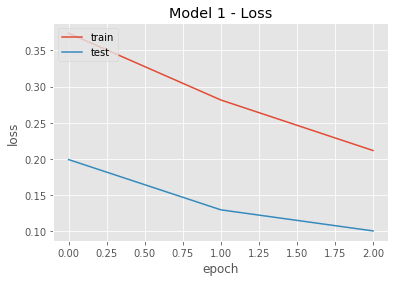

In [30]:
# import matplotlib.pyplot as plt
# # list all data in history
# print(history.history.keys())
# # summarize history for accuracy
# plt.plot(history.history['time_distributed_1_acc'])
# plt.plot(history.history['val_time_distributed_1_acc'])
# plt.title('Model 1 - Accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # ............................................................
plt.plot(history.history['time_distributed_3_loss'])
plt.plot(history.history['time_distributed_4_loss'])
# plt.plot(history.history['val_time_distributed_1_loss'])
plt.title('Model 1 - Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# # ............................................................
# plt.plot(history.history['time_distributed_1_recall_m'])
# plt.plot(history.history['val_time_distributed_1_recall_m'])
# plt.title('Model 1 - Recall')
# plt.ylabel('recall')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# # ............................................................
# plt.plot(history.history['time_distributed_1_precision_m'])
# plt.plot(history.history['val_time_distributed_1_precision_m'])
# plt.title('Model 1 - Precision')
# plt.ylabel('precision')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()


# # ............................................................
# plt.plot(history.history['time_distributed_1_f1_m'])
# plt.plot(history.history['val_time_distributed_1_f1_m'])
# plt.title('Model 1 - F1-Score')
# plt.ylabel('f1-score')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()


In [31]:
# import matplotlib.pyplot as plt
# # list all data in history
# print(history.history.keys())
# # summarize history for accuracy
# plt.plot(history.history['time_distributed_2_acc'])
# plt.plot(history.history['val_time_distributed_2_acc'])
# plt.title('Model 2 - Accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # ............................................................
# plt.plot(history.history['time_distributed_2_loss'])
# plt.plot(history.history['val_time_distributed_2_loss'])
# plt.title('Model 2 - Loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# # ............................................................
# plt.plot(history.history['time_distributed_2_recall_m'])
# plt.plot(history.history['val_time_distributed_2_recall_m'])
# plt.title('Model 2 - Recall')
# plt.ylabel('recall')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# # ............................................................
# plt.plot(history.history['time_distributed_2_precision_m'])
# plt.plot(history.history['val_time_distributed_2_precision_m'])
# plt.title('Model 2 - Precision')
# plt.ylabel('precision')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()


# # ............................................................
# plt.plot(history.history['time_distributed_2_f1_m'])
# plt.plot(history.history['val_time_distributed_2_f1_m'])
# plt.title('Model 2 - F1-Score')
# plt.ylabel('f1-score')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.grid()
# plt.show()

# # ............................................................
# plt.plot(history.history['time_distributed_2_precision_m'])
# plt.plot(history.history['time_distributed_2_recall_m'])
# plt.plot(history.history['time_distributed_2_f1_m'])
# plt.title('Model 2 - F1-Score')
# plt.title('Model 2 - F1-Score')
# plt.ylabel('precision')
# plt.xlabel('epoch')
# plt.legend(['precision', 'recall','f1-score'], loc='upper left')
# plt.grid()
# plt.show()

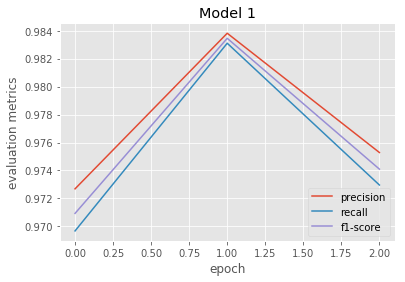

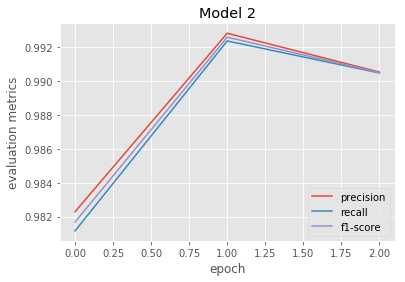

In [32]:

# .......................................
plt.plot(history.history['time_distributed_3_precision_m'])
plt.plot(history.history['time_distributed_3_recall_m'])
plt.plot(history.history['time_distributed_3_f1_m'])
plt.title('Model 1')

plt.ylabel('evaluation metrics')
plt.xlabel('epoch')
plt.legend(['precision', 'recall','f1-score'], loc='lower right')
# ax = plt.axes()
# ax.set_facecolor("white")
# plt.grid()
plt.show()


# ..................................................

plt.plot(history.history['time_distributed_4_precision_m'])
plt.plot(history.history['time_distributed_4_recall_m'])
plt.plot(history.history['time_distributed_4_f1_m'])
plt.title('Model 2')

plt.ylabel('evaluation metrics')
plt.xlabel('epoch')
plt.legend(['precision', 'recall','f1-score'], loc='lower right')
# ax = plt.axes()
# ax.set_facecolor("white")
# plt.grid()
plt.show()

In [33]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report


In [34]:
test_pred = model.predict(X_te, verbose=1)

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[ 193, 4568, 2287, ...,    0,    0,    0],
       [  21, 1592,  933, ...,    0,    0,    0],
       [   3, 1554,  568, ...,    0,    0,    0],
       ...,
       [   3, 2816,    1, ...,    0, ...

In [ ]:
# test_pred1 = model.predict(X_te, verbose=1)

In [ ]:
# test_pred = np.argmax(test_pred, axis=-1)

In [ ]:
# test_pred[0][0]

In [ ]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
# pred_labels = pred2label(test_pred)
test_labels1 = pred2label(y_te)
test_labels2 = pred2label(y1_te)

In [ ]:
idx2tag = {i: w for w, i in tag2idx.items()}
idx2tag2 = {i: w for w, i in tag22idx.items()}


def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out
def pred2label2(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag2[p_i])
        out.append(out_i)
    return out
    
pred_labels1 = pred2label(test_pred[0])
pred_labels2 = pred2label2(test_pred[1])
test_labels1 = pred2label(y_te)
test_labels2 = pred2label2(y1_te)

In [ ]:
# test_pred[0]

In [ ]:
print("1: F1-score: {:.1%}".format(f1_score(test_labels1, pred_labels1)))
print("2: F1-score: {:.1%}".format(f1_score(test_labels2, pred_labels2)))


In [ ]:
print(classification_report(test_labels1, pred_labels1))
print(classification_report(test_labels2, pred_labels2))


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(test_labels1,pred_labels1)
print(cm)

In [ ]:
i = 101
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
print('.....................................................................................')
# print(p[0][0])
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w, pred,pred1 in zip(X_te[i], p[0][0], p[1][0]):
    print("{}    {}".format(list(tags)[pred],list(tags2)[pred1]))
print('.....................................................................................')    
# # print(p[1][0])
# for w, pred1 in zip(X_te[i], p[1][0]):
#     print("{}".format( list(tags2)[pred1]))

In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred_class)
print(cm)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred1 = model.predict(X_te)
y_pred = np.argmax(y_pred1, axis=1)

# Print f1, precision, and recall scores
print(precision_score(y_te, y_pred[0] , average="macro"))
print(recall_score(y_te, y_pred[0] , average="macro"))
print(f1_score(y_te, y_pred[0] , average="macro"))